<pre>
baseline model 을 실행해 보겠습니다.

당 competetion의 공식 baseline model은 <a href="https://github.com/KbeautyHair/KbeautyBaseline">https://github.com/KbeautyHair/KbeautyBaseline</a>입니다. baseline model의 공식 저작자와 기술에 대한 정보를 얻고 싶다면 앞의 github link를 참조하세요
</pre>

<pre>먼저, baseline github를 clone 합니다.
이 jupyter notebook docker에 세팅된 current path 는 /main/notebooks 이므로 이 아래에 들어오게 됩니다.
</pre>

In [6]:
!cd /main && ls -al

total 48
drwxr-xr-x  8 root root 4096 Jan 31 21:32  .
drwxr-xr-x  1 root root 4096 Jan 31 21:31  ..
drwxr-xr-x  8 root root 4096 Jan 31 15:19  .git
-rw-r--r--  1 root root  132 Jan 31 14:41  .gitignore
-rw-r--r--  1 root root  873 Jan 31 13:18  README.md
-rw-r--r--  1 root root 1030 Jan 31 21:30 '\'
drwxr-xr-x 13 root root 4096 Jan 31 14:15  dataset
drwxr-xr-x  2 root root 4096 Jan 31 21:29  environ
drwxr-xr-x  2 root root 4096 Jan 31 21:01  environ2
drwxr-xr-x  5 root root 4096 Jan 31 13:23  jupyter_settings
drwxr-xr-x  5 root root 4096 Jan 31 21:32  notebooks
-rw-r--r--  1 root root 1030 Jan 31 21:32  run.sh


In [8]:
!cd /main/notebooks && ls

KbeautyBaseline  dataset_describe.ipynb    main.ipynb
Untitled.ipynb	 inference_baseline.ipynb


In [1]:
!git clone https://github.com/KbeautyHair/KbeautyBaseline.git

Cloning into 'KbeautyBaseline'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 157 (delta 4), reused 0 (delta 0), pack-reused 148
Receiving objects: 100% (157/157), 4.44 MiB | 3.25 MiB/s, done.
Resolving deltas: 100% (66/66), done.


<pre>
두 번째로, baseline의 공식 설명에 따르면, pretrained 파일을 불러오기 위해서는 가중치파일을 다운받아야 합니다.
공식 모델 github에도 존재하지만, 대회를 위해 바로 다운로드 가능한 endpoint에서 한시적으로 serving 할 예정입니다.

용량이 상당하므로 본인의 컴퓨터가 네트워크가 느리다면 차라도 한잔 하고 오는 것을 추천합니다.
</pre>

In [10]:
import os
!mkdir -p /main/notebooks/KbeautyBaseline/expr/checkpoints/k-hairstyle/
!cd /main/notebooks/KbeautyBaseline/expr/checkpoints/k-hairstyle/ && wget https://robot-public.s3.ap-northeast-2.amazonaws.com/baseline/060000_nets_ema.ckpt
!cd /main/notebooks/KbeautyBaseline/expr/checkpoints/k-hairstyle/ && wget https://robot-public.s3.ap-northeast-2.amazonaws.com/baseline/060000_nets.ckpt
!cd /main/notebooks/KbeautyBaseline/expr/checkpoints/k-hairstyle/ && wget https://robot-public.s3.ap-northeast-2.amazonaws.com/baseline/060000_nets_optims.ckpt    

--2021-01-31 21:34:01--  https://robot-public.s3.ap-northeast-2.amazonaws.com/baseline/060000_nets_ema.ckpt
Resolving robot-public.s3.ap-northeast-2.amazonaws.com (robot-public.s3.ap-northeast-2.amazonaws.com)... 52.219.60.11
Connecting to robot-public.s3.ap-northeast-2.amazonaws.com (robot-public.s3.ap-northeast-2.amazonaws.com)|52.219.60.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229463581 (219M) [application/x-www-form-urlencoded]
Saving to: ‘060000_nets_ema.ckpt’

060000_nets_ema.ckp 100%[===================>] 218.83M  97.1MB/s    in 2.3s    

2021-01-31 21:34:04 (97.1 MB/s) - ‘060000_nets_ema.ckpt’ saved [229463581/229463581]

--2021-01-31 21:34:04--  https://robot-public.s3.ap-northeast-2.amazonaws.com/baseline/060000_nets.ckpt
Resolving robot-public.s3.ap-northeast-2.amazonaws.com (robot-public.s3.ap-northeast-2.amazonaws.com)... 52.219.60.11
Connecting to robot-public.s3.ap-northeast-2.amazonaws.com (robot-public.s3.ap-northeast-2.amazonaws.com

In [12]:
#import 를 무사히 하기 위한 처리
import sys
sys.path.append('/main/notebooks/KbeautyBaseline')

In [13]:
#여기부터 baseline model 의 main.py 를 그대로 가져왔습니다.
"""
StarGAN v2
Copyright (c) 2020-present NAVER Corp.

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.
"""

import os
import argparse

from munch import Munch
from torch.backends import cudnn
import torch

from KbeautyBaseline.core.data_loader import get_train_loader, get_val_loader
from KbeautyBaseline.core.solver import Solver


def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]


def main(args):
    print(args)
    cudnn.benchmark = True
    torch.manual_seed(args.seed)

    solver = Solver(args)
    if args.mode == 'train':
        loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                             which='source',
                                             img_size=args.img_size,
                                             batch_size=args.batch_size,
                                             prob=args.randcrop_prob,
                                             num_workers=args.num_workers,
                                             dataset_dir=args.dataset_dir
                                             ),
                        ref=get_train_loader(root=args.train_img_dir,
                                             which='reference',
                                             img_size=args.img_size,
                                             batch_size=args.batch_size,
                                             prob=args.randcrop_prob,
                                             num_workers=args.num_workers,
                                             dataset_dir=args.dataset_dir
                                             ),
                        val=get_val_loader(root=args.val_img_dir,
                                            img_size=args.img_size,
                                            batch_size=args.val_batch_size,
                                            shuffle=True,
                                            num_workers=args.num_workers,
                                            dataset_dir=args.dataset_dir
                                            )
                        )
        solver.train(loaders)
    elif args.mode == 'sample':
        solver.sample()
    elif args.mode == 'eval':
        fid_values, fid_mean = solver.evaluate()
        for key, value in fid_values.items():
            print(key, value)
    else:
        raise NotImplementedError

In [14]:
#py의 args를 ipython 용으로 개조함
class args_ipython():
    def __init__(self):
        pass
    
    def __str__(self):
        import json
        return json.dumps(self.__dict__, ensure_ascii=False, indent=4)
    
    def __repr__(self):
        return self.__str__()
    
class args_ipython_generator():    
    def add_argument(self, name, **kwargs):
        t = kwargs.get('type',str)
        d = kwargs.get('default','')
        h = kwargs.get('help','')        
        self.dic[name.replace('--','')] = {'type':t, 'default':d, 'help':h, 'value':d}
        
    def setdata(self, name, val):
        if name not in self.dic:        
            raise Exception(f"there's no parameter {name}")        
        if type(val) != self.dic[name]['type']:
            raise Exception(f"{name}'s parameter must be {self.dic[name]['type']} but {type(val)} passed.")
        self.dic[name]['value'] = val
    
    def __init__(self):
        self.dic = {}
        
    def parse_args(self):
        rtv = args_ipython()
        for k, v in self.dic.items():
            setattr(rtv, k, v['value'])
        return rtv

In [15]:
parser = args_ipython_generator()
parser.add_argument('--img_size', type=int, default=512,
                    help='Image resolution')
parser.add_argument('--num_domains', type=int, default=2,
                    help='Number of domains')
parser.add_argument('--latent_dim', type=int, default=16,
                    help='Latent vector dimension')
parser.add_argument('--hidden_dim', type=int, default=512,
                    help='Hidden dimension of mapping network')
parser.add_argument('--style_dim', type=int, default=64,
                    help='Style code dimension')

# weight for objective functions
parser.add_argument('--lambda_reg', type=float, default=1,
                    help='Weight for R1 regularization')
parser.add_argument('--lambda_cyc', type=float, default=2,
                    help='Weight for cyclic consistency loss')
parser.add_argument('--lambda_sty', type=float, default=2,
                    help='Weight for style reconstruction loss')
parser.add_argument('--lambda_ds', type=float, default=1,
                    help='Weight for diversity sensitive loss')
parser.add_argument('--ds_iter', type=int, default=100000,
                    help='Number of iterations to optimize diversity sensitive loss')
parser.add_argument('--w_hpf', type=float, default=0,
                    help='weight for high-pass filtering')

# training arguments
parser.add_argument('--randcrop_prob', type=float, default=0.5,
                    help='Probabilty of using random-resized cropping')
parser.add_argument('--total_iters', type=int, default=100000,
                    help='Number of total iterations')
parser.add_argument('--resume_iter', type=int, default=0,
                    help='Iterations to resume training/testing')
parser.add_argument('--batch_size', type=int, default=8,
                    help='Batch size for training')
parser.add_argument('--val_batch_size', type=int, default=32,
                    help='Batch size for validation')
parser.add_argument('--lr', type=float, default=1e-4,
                    help='Learning rate for D, E and G')
parser.add_argument('--f_lr', type=float, default=1e-6,
                    help='Learning rate for F')
parser.add_argument('--beta1', type=float, default=0.0,
                    help='Decay rate for 1st moment of Adam')
parser.add_argument('--beta2', type=float, default=0.99,
                    help='Decay rate for 2nd moment of Adam')
parser.add_argument('--weight_decay', type=float, default=1e-4,
                    help='Weight decay for optimizer')

# misc
parser.add_argument('--mode', type=str, required=True,
                    choices=['train', 'sample', 'eval'],
                    help='This argument is used in solver')
parser.add_argument('--num_workers', type=int, default=8,
                    help='Number of workers used in DataLoader')
parser.add_argument('--seed', type=int, default=777,
                    help='Seed for random number generator')

# directory for training
parser.add_argument('--train_img_dir', type=str, default='data/mqset',
                    help='Directory containing training images')
parser.add_argument('--val_img_dir', type=str, default='data/mqset',
                    help='Directory containing validation images')
parser.add_argument('--test_img_dir', type=str, default='data/mqset',
                    help='Directory containing test images')
parser.add_argument('--sample_dir', type=str, default='expr/samples/k-hairstyle',
                    help='Directory for saving generated images')
parser.add_argument('--checkpoint_dir', type=str, default='expr/checkpoints/k-hairstyle',
                    help='Directory for saving network checkpoints')
parser.add_argument('--dataset_dir', type=str, default='imagelists',
                    help='Directory of train, valid image lists (npy files)')

# directory for calculating metrics
parser.add_argument('--eval_dir', type=str, default='expr/eval/k-hairstyle',
                    help='Directory for saving metrics, i.e., FID and LPIPS')

# directory for testing
parser.add_argument('--result_dir', type=str, default='expr/results/k-hairstyle',
                    help='Directory for saving generated images')
parser.add_argument('--src_dir', type=str, default='sample_images/src',
                    help='Directory containing input source images')
parser.add_argument('--ref_dir', type=str, default='sample_images/ref',
                    help='Directory containing input reference images')

parser.add_argument('--src_domain', type=int, default=0,
                    help='Source domain (e.g., 0, 1)')
parser.add_argument('--trg_domain', type=int, default=1,
                    help='Target domain (e.g., 0, 1)')
parser.add_argument('--num_sample', type=int, default=300,
                    help='Number of samples to generate')

# face alignment (not used in k-hairstyle baseline)
parser.add_argument('--wing_path', type=str, default='expr/checkpoints/wing.ckpt')
parser.add_argument('--lm_path', type=str, default='expr/checkpoints/celeba_lm_mean.npz')

# step size
parser.add_argument('--print_every', type=int, default=10)
parser.add_argument('--sample_every', type=int, default=5000)
parser.add_argument('--save_every', type=int, default=10000)
parser.add_argument('--eval_every', type=int, default=30000)



<pre>
아래의 패러매터는 다음과 같습니다.

!cd /main/notebooks/KbeautyBaseline && \
    python3 main.py --mode sample --img_size 512 --num_domains 2 --resume_iter 60000 \
    --w_hpf 0 --checkpoint_dir expr/checkpoints/k-hairstyle --result_dir expr/results/k-hairstyle \
    --trg_domain 0 --src_dir sample_images/src --ref_dir sample_images/ref
</pre>

In [20]:
parser.setdata('mode','sample')
parser.setdata('img_size',512)
parser.setdata('num_domains',2)
parser.setdata('resume_iter',60000)
parser.setdata('w_hpf',0.0)
parser.setdata('checkpoint_dir','/main/notebooks/KbeautyBaseline/expr/checkpoints/k-hairstyle')
parser.setdata('result_dir','/main/notebooks/KbeautyBaseline/expr/results/k-hairstyle')
#0번 폴더 버그 방지
!rm -rf sample_images/src/0/.ipynb_checkpoints
trg_domain = 0
parser.setdata('trg_domain',trg_domain)
parser.setdata('src_dir','/main/notebooks/KbeautyBaseline/sample_images/src')
parser.setdata('ref_dir','/main/notebooks/KbeautyBaseline/sample_images/ref')

입력에 쓰일 그림을 확인해 봅니다.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


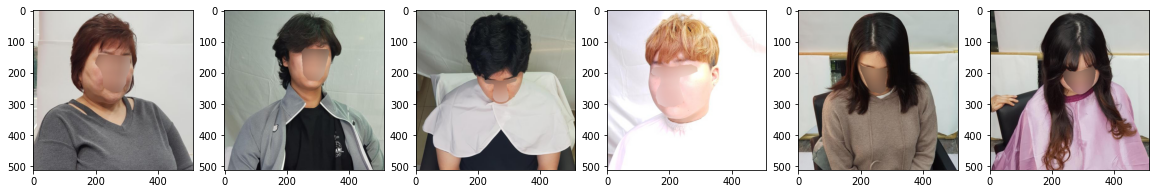

In [45]:
from PIL import Image
import os
import matplotlib.pyplot as plt
path = f'/main/notebooks/KbeautyBaseline/sample_images/src/{trg_domain}'
before_images = [Image.open(f'{path}/{i}') for i in sorted(os.listdir(path))]
plt.figure(figsize=(20,20))
for i, b in enumerate(before_images):
    plt.subplot(len(before_images)/6+1, 6, i+1)
    plt.imshow(b)

각 그림을 다음의 헤어스타일로 변화시킬 것입니다.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """


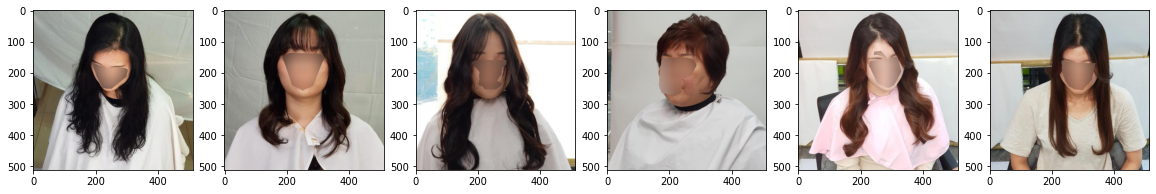

In [46]:
path = f'/main/notebooks/KbeautyBaseline/sample_images/ref/{trg_domain}'
ref_images = [Image.open(f'{path}/{i}') for i in sorted(os.listdir(path))]
plt.figure(figsize=(20,20))
for i, b in enumerate(ref_images):
    plt.subplot(len(ref_images)/6+1, 6, i+1)
    plt.imshow(b)

<pre>
실행환경을 검사합니다.
해당 환경에서 문제없이 굴러갑니다.
</pre>

In [22]:
import torch
if torch.cuda.is_available():
    print("device :",torch.cuda.get_device_name(0))
else:
    print("device : cpu only")

print("torch version :",torch.__version__)
!nvidia-smi

device : Tesla T4
torch version : 1.7.1
Sun Jan 31 21:37:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   28C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

In [23]:
args = parser.parse_args()
main(args)

{
    "img_size": 512,
    "num_domains": 2,
    "latent_dim": 16,
    "hidden_dim": 512,
    "style_dim": 64,
    "lambda_reg": 1,
    "lambda_cyc": 2,
    "lambda_sty": 2,
    "lambda_ds": 1,
    "ds_iter": 100000,
    "w_hpf": 0.0,
    "randcrop_prob": 0.5,
    "total_iters": 100000,
    "resume_iter": 60000,
    "batch_size": 8,
    "val_batch_size": 32,
    "lr": 0.0001,
    "f_lr": 1e-06,
    "beta1": 0.0,
    "beta2": 0.99,
    "weight_decay": 0.0001,
    "mode": "sample",
    "num_workers": 8,
    "seed": 777,
    "train_img_dir": "data/mqset",
    "val_img_dir": "data/mqset",
    "test_img_dir": "data/mqset",
    "sample_dir": "expr/samples/k-hairstyle",
    "checkpoint_dir": "/main/notebooks/KbeautyBaseline/expr/checkpoints/k-hairstyle",
    "dataset_dir": "imagelists",
    "eval_dir": "expr/eval/k-hairstyle",
    "result_dir": "/main/notebooks/KbeautyBaseline/expr/results/k-hairstyle",
    "src_dir": "/main/notebooks/KbeautyBaseline/sample_images/src",
    "ref_dir": "/main/

  0%|          | 0/6 [00:00<?, ?it/s]

Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Loading checkpoint from /main/notebooks/KbeautyBaseline/expr/checkpoints/k-hairstyle/060000_nets_ema.ckpt...
Src len:  6 Trg len:  6


 83%|████████▎ | 5/6 [00:02<00:00,  2.02it/s]


<pre>
변환된 결과물 파일을 비교 검사해 봅시다.

위쪽 = before
가운데 = style
오른쪽 = before + style 변환완료 입니다.
</pre>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


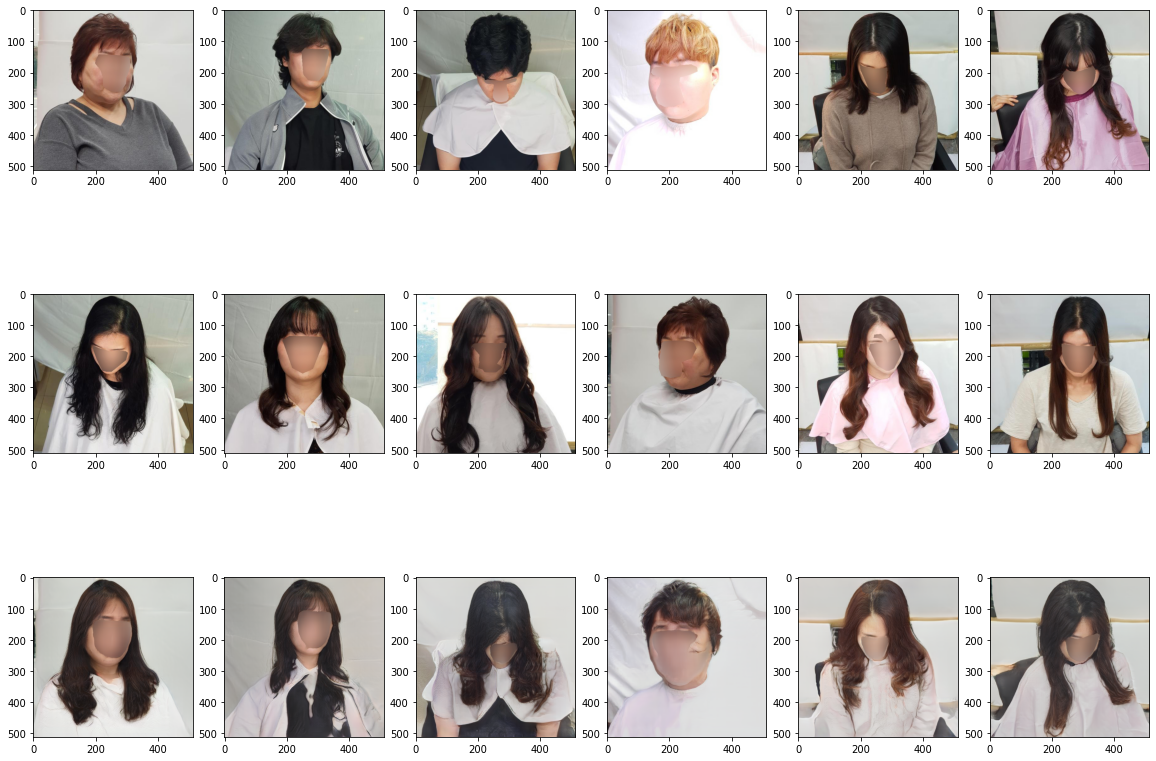

In [47]:
path = f'/main/notebooks/KbeautyBaseline/expr/results/k-hairstyle/{trg_domain}'
after_images = [Image.open(f'{path}/{i}') for i in sorted(os.listdir(path))]

plt.figure(figsize=(20,20))
before_after = before_images + ref_images + after_images
for i, image in enumerate(before_after):
    plt.subplot(len(before_after)/6 + 1, 6, i+1)
    plt.imshow(image)